# Intelligent Information Retreival - Final Project
## Genre Classification of Feature Films

Data Set Source: https://www.kaggle.com/hijest/genre-classification-dataset-imdb/version/1

Training Data Size:
Test Data Size: 

## Packages and Data Import

In [184]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from nltk.corpus import stopwords
from collections import Counter
import nltk
from sklearn.feature_extraction.text import CountVectorizer
# nltk.download('punkt')
# nltk.download('stopwords')


In [185]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

In [186]:
colNames = ['id','title','genre','descr']
dfTrain = pd.read_csv('train_data.txt',delimiter=':::',names=colNames)
dfTrain['genre'] = dfTrain['genre'].apply(lambda x: x.strip())
dfTrain['genre'] = dfTrain['genre'].astype('category')
dfTrain['_label_'] = dfTrain['genre'].cat.codes

C:\Users\tate5\AppData\Local\Temp\ipykernel_7892\3529705301.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfTrain = pd.read_csv('train_data.txt',delimiter=':::',names=colNames)


In [182]:
dfTrain['genre'].value_counts(normalize=True)


drama          0.251098
documentary    0.241561
comedy         0.137363
short          0.093574
horror         0.040654
thriller       0.029347
action         0.024256
western        0.019036
reality-tv     0.016306
family         0.014461
adventure      0.014295
music          0.013484
romance        0.012395
sci-fi         0.011934
adult          0.010883
crime          0.009315
animation      0.009186
sport          0.007968
talk-show      0.007212
fantasy        0.005958
mystery        0.005884
musical        0.005109
biography      0.004888
history        0.004482
game-show      0.003578
news           0.003339
war            0.002435
Name: genre, dtype: float64

Unbalanced classes making accurate identification difficult, three possible approaches: 
* subsample the data to get balanced classes(genres) with more than 999 movies for each
* regroup by more general categories (requires subjective and manual grouping)
* SMOTE Over/Under sampling of data

https://www.filmsite.org/genres.html

In [4]:
dfTrain['genre'].value_counts()

drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: genre, dtype: int64

In [224]:
dfTrain['_label_'] = dfTrain.genre.copy()
dfTrain['_label_'].replace('action',1,inplace=True)
dfTrain['_label_'].replace('thriller', 1,inplace=True)
dfTrain['_label_'].replace('adventure', 2,inplace=True)
dfTrain['_label_'].replace('mystery', 2,inplace=True)
dfTrain['_label_'].replace('comedy', 3,inplace=True)
dfTrain['_label_'].replace('crime', 4,inplace=True)
dfTrain['_label_'].replace('drama', 5,inplace=True)
dfTrain['_label_'].replace('romance', 5,inplace=True)
dfTrain['_label_'].replace('adult', 5,inplace=True)
dfTrain['_label_'].replace('history', 6,inplace=True)
dfTrain['_label_'].replace('biography', 6,inplace=True)
dfTrain['_label_'].replace('war', 6,inplace=True)
dfTrain['_label_'].replace('news', 6,inplace=True)
dfTrain['_label_'].replace('horror', 7,inplace=True)
dfTrain['_label_'].replace('music', 8,inplace=True)
dfTrain['_label_'].replace('musical', 8,inplace=True)
dfTrain['_label_'].replace('sci-fi', 9,inplace=True)
dfTrain['_label_'].replace('fantasy', 9,inplace=True)
dfTrain['_label_'].replace('documentary', 10,inplace=True)
dfTrain['_label_'].replace('short', 10,inplace=True)
dfTrain['_label_'].replace('reality-tv', 11,inplace=True)
dfTrain['_label_'].replace('family', 11,inplace=True)
dfTrain['_label_'].replace('animation', 11,inplace=True)
dfTrain['_label_'].replace('sport', 11,inplace=True)
dfTrain['_label_'].replace('talk-show', 11,inplace=True)
dfTrain['_label_'].replace('game-show', 11,inplace=True)
dfTrain['_label_'].replace('western', 12,inplace=True)

dfTrain = dfTrain.groupby('_label_').head(500).reset_index(drop=True)

Below code will grab just the genres with > then 999 samples and take the top 1000 from each, however this would mean that all other genre types would need to be classified as other. Because of the similarity between genres like thriller and action this seemed like a less than optimal strategy to take.

In [143]:
# dfTrain = dfTrain.groupby('genre').filter(lambda x: len(x) > 999)
# dfTrain = dfTrain.groupby('genre').head(1000).reset_index(drop=True)

In [146]:
# dfTrain['genre'] = dfTrain['genre'].astype('category')
# dfTrain['_label_'] = dfTrain['genre'].cat.codes

Left the following genre's to classify

In [6]:
dfTrain['_label_'].value_counts()

5     500
1     500
10    500
3     500
4     500
11    500
7     500
9     500
8     500
2     500
12    500
6     500
Name: _label_, dtype: int64

## Exploratory Analysis

In [84]:
dfTrain.head()

,id,title,genre,descr,label
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,8
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,24
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,8
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,8


In [83]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      54214 non-null  int64   
 1   title   54214 non-null  object  
 2   genre   54214 non-null  category
 3   descr   54214 non-null  object  
 4   label   54214 non-null  int8    
dtypes: category(1), int64(1), int8(1), object(2)
memory usage: 1.3+ MB


In [187]:
dfTrain['year'] = dfTrain['title'].str[-6:]
dfTrain['year'] = dfTrain['year'].str[:4]
dfTrain['year'] = pd.to_numeric(dfTrain['year'].astype(str).str.replace(',',''), errors='coerce').fillna(0).astype(int)

In [21]:
dfTrain.head()

,id,title,genre,descr,year
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,2009
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,1997
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,1980
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1915
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,2007


In [24]:
dfTrain.year.value_counts()

0       4344
2016    3048
2017    3018
2015    2740
2014    2324
        ... 
1896       3
1904       2
1895       2
2021       2
2022       1
Name: year, Length: 129, dtype: int64

Text(0, 0.5, 'Counts')

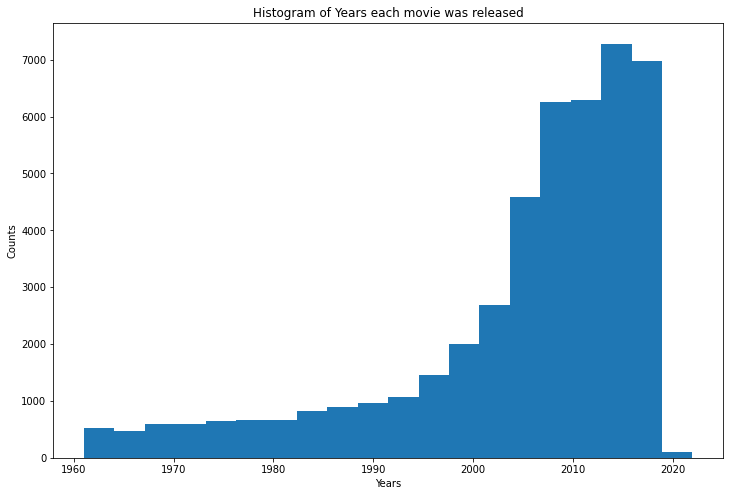

In [188]:
dfTrain[dfTrain['year'] > 1960].hist('year',grid=False,figsize=(12,8),bins=20)
plt.title('Histogram of Years each movie was released')
plt.xlabel('Years')
plt.ylabel('Counts')

## Clean text

In [225]:
stops = stopwords.words('english')
porter = nltk.stem.PorterStemmer()

dfTrain['descr'] = dfTrain['descr'].str.replace('[^a-zA-Z]',' ', regex=True)
dfTrain['noStopWords'] = dfTrain['descr'].apply(lambda x: [word.lower() for word in x.split() if word.lower() not in stops])
dfTrain['stemmed'] = dfTrain['noStopWords'].apply(lambda y:[porter.stem(word) for word in y])

### Need to find way to remove the words that show up under n times to reduce final Doc x term freq matrix size and keep core concepts

#### Can possibly do it through removing words that show up < N times across all documents 

In [190]:
allWords = np.asarray(dfTrain.stemmed)
fullSet = [word for sent in allWords for word in sent]
cnt = Counter(fullSet)

In [191]:
print(f'# of words: {len(fullSet):,}')

# of words: 3,115,240


In [192]:
print(f'# of Unique Words: {len(cnt):,}')

# of Unique Words: 89,316


In [235]:
cnt.most_common()[-100:]

[('asst', 1),
 ('bonacorsi', 1),
 ('scrubland', 1),
 ('guillaum', 1),
 ('riq', 1),
 ('amraoui', 1),
 ('canadair', 1),
 ('dalgaard', 1),
 ('beckett', 1),
 ('buerger', 1),
 ('goodman', 1),
 ('backstab', 1),
 ('bjarn', 1),
 ('stergaard', 1),
 ('madsen', 1),
 ('hern', 1),
 ('gind', 1),
 ('krimi', 1),
 ('politig', 1),
 ('rden', 1),
 ('finist', 1),
 ('binita', 1),
 ('tshere', 1),
 ('gyeltshen', 1),
 ('misdiagnos', 1),
 ('karadsheh', 1),
 ('whistleblow', 1),
 ('pavement', 1),
 ('pape', 1),
 ('dade', 1),
 ('snezhkin', 1),
 ('drafter', 1),
 ('liuzhiyuan', 1),
 ('kuiyong', 1),
 ('xao', 1),
 ('magan', 1),
 ('pangzi', 1),
 ('ecrivain', 1),
 ('historien', 1),
 ('avoir', 1),
 ('achev', 1),
 ('tude', 1),
 ('merair', 1),
 ('editeur', 1),
 ('gre', 1),
 ('cinq', 1),
 ('ravissant', 1),
 ('secretair', 1),
 ('particuli', 1),
 ('seduit', 1),
 ('vieill', 1),
 ('veuv', 1),
 ('melisa', 1),
 ('italienn', 1),
 ('celui', 1),
 ('autor', 1),
 ('soll', 1),
 ('letzt', 1),
 ('werk', 1),
 ('rzlich', 1),
 ('verstorbenen

In [236]:
uncommonWords = Counter({key: c for key,c in cnt.items() if c <= 10})

In [237]:
print(f'# of uncommon words to remove: {len(uncommonWords):,}')

# of uncommon words to remove: 22,553


#### However we can see this will miss unimportant words that show multiple times but only in 1 document, lets try to remove words that show up in less than 3 different documents

In [229]:
dfTrain['unique'] = dfTrain['stemmed'].apply(lambda z: list(set(z)))

uniqueWords_by_doc = np.asarray(dfTrain['unique'])
flatUnique = [word for sent in uniqueWords_by_doc for word in sent]
docFreq = Counter(flatUnique)

print(f'# unique-document words: {len(flatUnique):,}')
print(f'# of unique words: {len(docFreq):,}')

# unique-document words: 280,188
# of unique words: 26,115


This is doing a similar process as above but instead of knowing how often a word appears across the entire set of words(irrespective of document) we can look at the number of documents a term appears across to find words that are unique to a specific movie as these would be less likely to contain specific information related to the broader class of genres.

We would expect to see the same length of dicitonary of **docFreq** as that of **cnt** above, just instead of term occurence the words represent # of documents occurences

In [227]:
### Remove words that show up in less than 3 documents
uncommonWords_byDoc = Counter({key: c for key,c in docFreq.items() if c < 2})
print(f'# of uncommon words across documents to remove: {len(uncommonWords_byDoc):,}')

# of uncommon words across documents to remove: 13,952


## Create Doc x TF matrix

We can see that we actually end up kicking out less words this way hopefully reducing the information that is thrown away for each genre given by a document, we can now remove the above words from our training set

In [230]:
dfTrain['reduced'] = dfTrain['stemmed'].apply(lambda a: ' '.join([word for word in a if word not in uncommonWords_byDoc]))

wordList = np.asarray(dfTrain['reduced'].apply(lambda x: x.split()))
totalWords = [word for sent in wordList for word in sent]
uniqWords = Counter(totalWords)

print(f'Total # of words: {len(totalWords):,}')
print(f'# of unique words: {len(uniqWords):,}')

Total # of words: 322,865
# of unique words: 12,163


In [197]:
vec = CountVectorizer()  
vectors = vec.fit_transform(dfTrain.reduced)
doctf = pd.DataFrame(vectors.todense().astype('uint8')) # decrease memory usage and we know because these are counts only upper bound for negative values use int8
doctf.columns = vec.get_feature_names_out()

In [198]:
doctf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Columns: 72242 entries, aa to zz
dtypes: uint8(72242)
memory usage: 3.6 GB


<AxesSubplot:title={'center':'Most Frequent Terms'}>

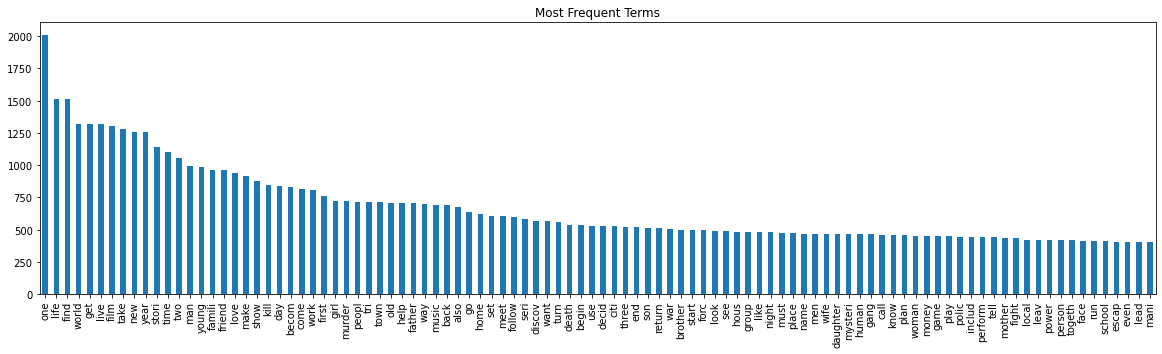

In [195]:
longestMovieDescription = doctf.sum(axis=1)
mostFreqTerms = doctf.sum(axis=0)

plt.figure(figsize=(20,5))
plt.title('Most Frequent Terms')
mostFreqTerms.nlargest(100).plot.bar()

<AxesSubplot:title={'center':'Longest Movie Descriptions'}>

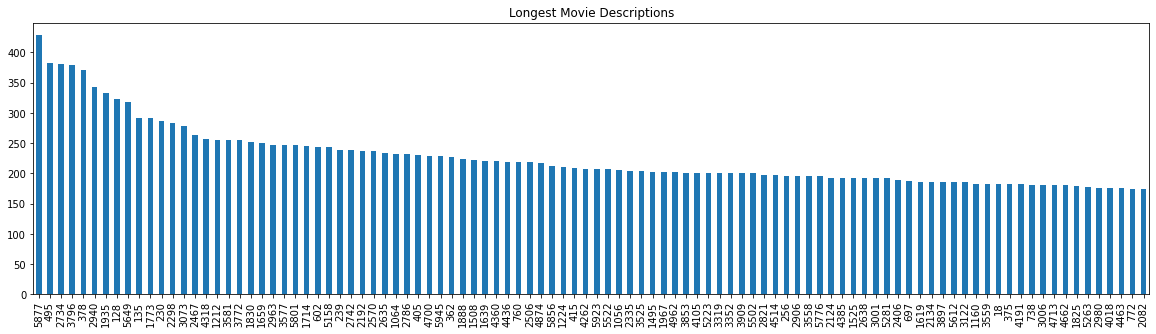

In [199]:
plt.figure(figsize=(20,5))
plt.title('Longest Movie Descriptions')
longestMovieDescription.nlargest(100).plot.bar()

In [207]:
print(f'Average Movie description length: {round(longestMovieDescription.mean())} words')
print(f'Median Movie description length: {round(longestMovieDescription.median())} words')

Average Movie description length: 52 words
Median Movie description length: 40 words


<AxesSubplot:title={'center':'Description Length Histogram'}, ylabel='Frequency'>

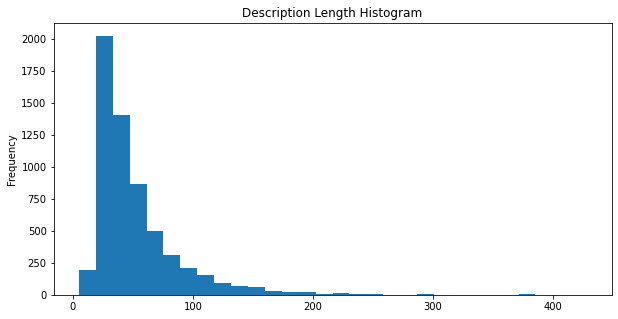

In [204]:
plt.figure(figsize=(10,5))
plt.title('Description Length Histogram')
longestMovieDescription.plot.hist(bins=30)

## Create TF x IDF matrix

In [208]:
def tf_x_idf(df):
    '''Create a function to find the TF x IDF weights for a given tf matrix'''
    N = df.shape[1]
    #count non zero inputs as the term occurs
    df['df'] = df.apply(np.count_nonzero,axis=1)
    #compute inverse term frequency 
    df['idf'] = np.log2(N/df['df']).astype(np.float16)
    #compute final weight matrix 
    tf_idf = df.iloc[:,:-2].multiply(df['idf'],axis='index')

    return tf_idf.astype(np.float16)

In [209]:
tf_idf = tf_x_idf(doctf.T)
tf_idf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72242 entries, aa to zz
Columns: 54214 entries, 0 to 54213
dtypes: float16(54214)
memory usage: 7.3+ GB


In [212]:
tf_idf.shape

(72242, 54214)

In [210]:
highestValueTerm = tf_idf.sum(axis=1)

<AxesSubplot:title={'center':'Highest Value Terms'}>

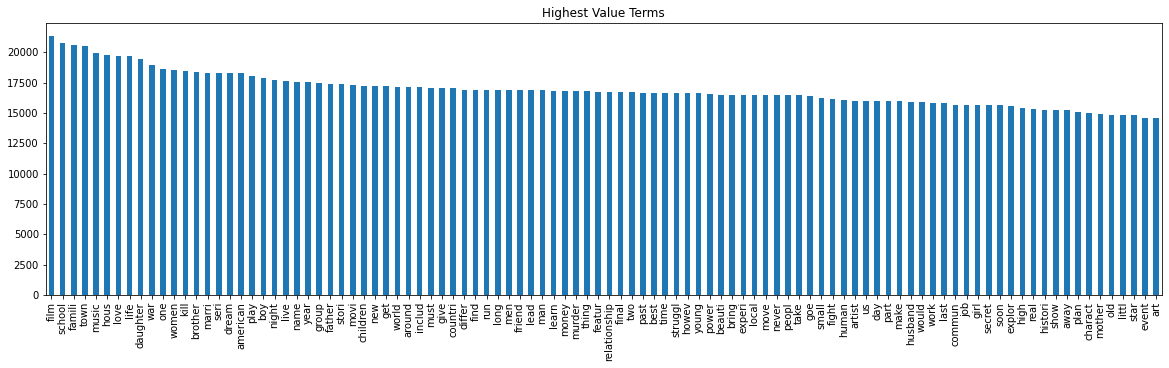

In [211]:
plt.figure(figsize=(20,5))
plt.title('Highest Value Terms')
highestValueTerm.nlargest(100).plot.bar()

Transform the TF x IDF matrix into training and testing set and transpose to a DF X Term matrix and add genre labels back

In [216]:
full = pd.concat([tf_idf.T,dfTrain['_label_']],axis=1)
train, test = train_test_split(full, test_size=0.2,stratify=full['_label_'])

## Rochio Classification

Implementation from Homework 4

In [220]:
def RocchioTrain(df):
    '''Takes in a doc x TF matrix with appended labels returns Prototype Vector & unique classes'''
    numWords = df.drop('_label_', axis = 1).shape[1]

    labels = np.asarray(df['_label_'].values)
    unique = np.unique(labels)

    prototypeVector = np.zeros((len(unique),numWords))
    for i in unique:

        prototypeVector[i-1] = np.asarray(df[df['_label_'] == i].sum())[:-1]

    return prototypeVector, unique


def RocchioClassification(prototypes, classes, testInstance):
    arr = testInstance[:-1]
    pred = {}
    for proto,class_ in zip(prototypes,classes):
        proto = proto.reshape(1, -1)
        prob = 1-spatial.distance.cosine(proto, arr)
        pred[class_] = prob

    maxKey = max(pred, key = pred.get)
    actual = testInstance[-1:]
    return maxKey, actual[0], pred[maxKey]

def accuracy(df, ptv, classes):
    '''Takes a test data set, posteriors and priors fr a trained doc x term matrix and returns accuracy of predictions'''
    testSet = df.values
    ### can use numpy sum with true/false & list comprehension to get one liner
    acc = np.asarray([RocchioClassification(ptv,classes,i)[0] == RocchioClassification(ptv,classes,i)[1] for i in testSet])
    
    return acc.sum() / len(acc)  

In [218]:
ptv, classes = RocchioTrain(train)

In [223]:
print(f'Accuracy over all test set is: {accuracy(test[:5000], ptv, classes):.2%}')

C:\Python310\lib\site-packages\scipy\spatial\distance.py:629: RuntimeWarning: overflow encountered in square
  vv = np.average(np.square(v), weights=w)


Accuracy over all test set is: 2.64%


Even with the more generaly grouping we still get results that are hardly high in terms of accuracy while selecting the correct class only slightly more than half the time. Yet it is interesting to see how the algorithm performed on each of the different Genres

In [ ]:
test['pred'] = [RocchioClassification(ptv,classes,x)[0] for x in test.values]
print(metrics.classification_report(test['_label_'],test['pred'],target_names=['Action','Adventure','Comedy','Crime','Drama','History','Horror','Music','Sci-Fi','Documentary','Other','Western']))

In [57]:
test['_label_'].value_counts()

8     100
1     100
12    100
4     100
2     100
9     100
11    100
7     100
3     100
6     100
5     100
10    100
Name: _label_, dtype: int64

In [59]:
test['pred'].value_counts()

5     156
10    126
4     112
8     109
7     108
11    101
12     99
9      93
3      79
6      76
2      71
1      70
Name: pred, dtype: int64

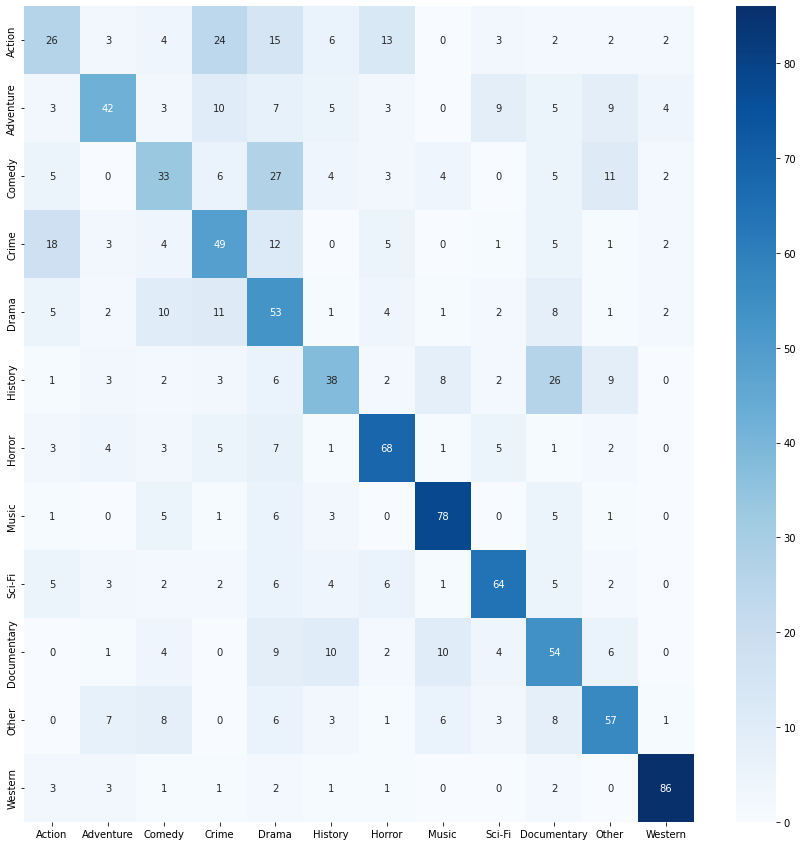

In [68]:
cf_mat = confusion_matrix(test['_label_'],test['pred'])
ls = ['Action','Adventure','Comedy','Crime','Drama','History','Horror','Music','Sci-Fi','Documentary','Other','Western']
fig, ax = plt.subplots(figsize=(15,15))
mat = sns.heatmap(cf_mat,annot=True,cmap=plt.cm.Blues,xticklabels=ls, yticklabels=ls)
# plt.xticks(['Action','Adventure','Comedy','Crime','Drama','History','Horror','Music','Sci-Fi','Documentary','Other','Western'])
# x-axis predicted y-axis true

In [132]:
from scipy import spatial 
def recommendations(df,q):
    docRank_q = []
    for i in range(df.shape[0]):
        doc = df.iloc[i].values
        query = q.values
        docRank_q.append(1-spatial.distance.cosine(doc,query))
    finDocRank = pd.DataFrame({'DocRank':docRank_q})

    return finDocRank

In [133]:
testInstance = test.iloc[2][:-1]#.drop('_label_',axis=1)
pred = RocchioClassification(ptv,classes,testInstance)[0]
pred

In [135]:

rec = recommendations(tf_idf.T,testInstance)

C:\Python310\lib\site-packages\scipy\spatial\distance.py:628: RuntimeWarning: overflow encountered in square
  uu = np.average(np.square(u), weights=w)


In [231]:
lookup = rec.sort_values('DocRank',ascending=False).index[1:6].values
sim = rec.sort_values('DocRank',ascending=False).values[1:6]

In [232]:
sim = rec.sort_values('DocRank',ascending=False).values[1:6]
sim

array([[0.29724594],
       [0.2413341 ],
       [0.23100207],
       [0.2033918 ],
       [0.20178809]])

In [233]:
dfTrain[['title','genre','descr']].loc[lookup]

,title,genre,descr
2460,King of the Wild Horses (1947),western,An orphan goes to live with his uncle and cou...
1688,Tranquility (2010/I),drama,JIMMY KOVAC is a line cook in a Los Angeles r...
4605,Bulldog Courage (1922),western,College athlete Jimmy Brent is sent to Wyomin...
740,The Clinging Vine (1926),comedy,Mannish ultra efficient A B is the real forc...
4214,Gun Runner (1949),western,Kate Diamond owns the Roaring Falls Trading P...


In [143]:
colNames = ['id','title','genre','descr']
tmp = pd.read_csv('test_data_solution.txt',delimiter=':::',names=colNames)

C:\Users\tate5\AppData\Local\Temp\ipykernel_7892\3980884408.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv('test_data_solution.txt',delimiter=':::',names=colNames)


In [144]:
tmp = tmp.iloc[:5]

In [147]:
descrip = '''Tate Noble returns to the town of his youth where as a boy his parents were murdered. His childhood friend Samuel, now the sheriff of La Mesa knows who is responsible, and Tate's arrival sparks hostility between Samuel and his father Judge Carter. As the mystery unravels, Tate and Samuel enlist help from an unlikely source, the mob, in order to bring to justice the man ultimately responsible, the evil Harcourt Simms.'''
title = 'Gunfight at La Mesa (2010)'
genre = 'western'

In [152]:
testTmp = pd.DataFrame({'id':9999,'title':title,'genre':'western','descr':descrip}, index=[0])